In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from scipy import stats
import os

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
from scroutines.miscu import is_in_polygon

In [2]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True):
    """customized scatter plot -- yesterday's progress
    """
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmax=vmax, cmap=cmap, rasterized=True)
        fig.colorbar(g, label=cbar_label, shrink=0.3)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

In [3]:
from scipy import spatial

def p_to_curve(query_point, pia_curve):
    """return the distance from a point to a set curve
    measure distance to each segment and take the min
    """
    tan_vec = pia_curve[1:] - pia_curve[:-1]
    # unit
    tan_vec = tan_vec/np.linalg.norm(tan_vec, axis=1).reshape(-1,1)
    norm_vec = tan_vec.dot(np.array([[0,-1],[1,0]]).T)
    # np.power(tan_vec[:,0],2)+np.power(tan_vec[:,1],2) # check normed

    query_vec = (query_point - pia_curve[:-1])
    d = np.min(np.abs(query_vec[:,0]*norm_vec[:,0] + query_vec[:,1]*norm_vec[:,1]))
    return d

def ps_to_curve(query_points, pia_curve):
    """return the distance from a set of points to a set curve
    """
    tan_vec = pia_curve[1:] - pia_curve[:-1]
    # unit
    tan_vec = tan_vec/np.linalg.norm(tan_vec, axis=1).reshape(-1,1)
    norm_vec = tan_vec.dot(np.array([[0,-1],[1,0]]).T)
    
    query_mtx = np.repeat(XY[:,np.newaxis,:], len(pia_curve)-1, axis=1) - pia_curve[:-1]
    ds = np.min(np.abs(query_mtx[:,:,0]*norm_vec[:,0] + query_mtx[:,:,1]*norm_vec[:,1]), axis=1)
    return ds

def binning(val, n):
    """
    """
    bins = np.linspace(np.min(val), np.max(val), n)
    binned = pd.cut(val, bins=bins)
    
    return bins, binned

In [4]:
class RefLineSegs:
    """
    """
    def __init__(self, ps):
        """
        line segments defined by ps
        """
        self.ps = ps
        self.rps = ps[:-1] # reference points (exclude the last point)
        self.ns = len(ps)-1 # number of segments
        # get ts and uts
        self.calc_tan_vec()
        
        return
    
    def calc_tan_vec(self):
        """get tangent vectors
        """
        ps = self.ps 
        ts = ps[1:] - ps[:-1]
        lts = np.linalg.norm(ts, axis=1)
        uts = ts/lts.reshape(-1,1)
        nuts = uts.dot(np.array([[0,-1],[1,0]]).T)
        
        # np.power(uts[:,0],2)+np.power(uts[:,1],2) # check normed
        
        self.ts = ts # tangents
        self.uts = uts # unitary tangents
        self.nuts = nuts # norm to unitary tangents
        
        self.lts = lts # tangent lengths
        self.cumlts = np.hstack([0,np.cumsum(lts)])[:-1] # cumulative tangent lengths
        
        return 
    
    def calc_seg_len(self):
        """get the length of each segment
        """
        ts = self.ts
        
        np.linalg.norm(ts, axis=1)
        
    
    
    def ndist_to_qp(self, query_point):
        """return the distance from a point to a set curve
        measure distance to each segment and take the min
        """
        query_vec = (query_point - self.rps)
        ndist = np.min(np.abs(query_vec[:,0]*self.nuts[:,0] + query_vec[:,1]*self.nuts[:,1]))
        
        return ndist
        
    def ndist_to_qps(self, XY):
        """return the distance from a point to a set curve
        measure distance to each segment and take the min
        """
        query_mtx = np.repeat(XY[:,np.newaxis,:], self.ns, axis=1) - self.rps
        tmp = np.abs(query_mtx[:,:,0]*self.nuts[:,0] + query_mtx[:,:,1]*self.nuts[:,1])
        ndists = np.min(tmp, axis=1)
        
        return ndists
        
    def tdist_to_qps(self, XY):
        """return the distance from a point to a set curve
        adds up the distance of each segment
        """
        
        query_mtx = np.repeat(XY[:,np.newaxis,:], self.ns, axis=1) - self.rps
        tmp = np.abs(query_mtx[:,:,0]*self.nuts[:,0] + query_mtx[:,:,1]*self.nuts[:,1])
        
        # which segment
        min_seg_idx = np.argmin(tmp, axis=1)
        
        # cumsum up to the segment
        tdists = self.cumlts[min_seg_idx]
        
        
        uts = self.uts[min_seg_idx] # tangent vector for each ref point
        qs_vec = XY - self.rps[min_seg_idx] # 
        tdists_correction = qs_vec[:,0]*uts[:,0] + qs_vec[:,1]*uts[:,1]
        
        return tdists+tdists_correction
        


# load input

In [5]:
np.random.seed(0)

In [6]:
directories = {
    'P14NR_ant': "merfish_06142023/ant/region0", 
    'P14NR_pos': "merfish_06142023/pos/region0",
               
    'P28NR_ant': "merfish_06142023/ant/region1",
    'P28NR_pos': "merfish_06142023/pos/region1",
               
    'P21DR_ant': "merfish_20231114/region0",
    'P21DR_pos': "merfish_20231120/region0",
               
    'P28DR_ant': "merfish_20231114/region1",
    'P28DR_pos': "merfish_20231120/region1",
               
    'P21NR_ant': "merfish_20231114/region2",
    'P21NR_pos': "merfish_20231120/region2",
}

In [7]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240227"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized"
!mkdir -p $outdir
!mkdir -p $outdatadir

In [8]:
dfs = []
names = ['P21DR_ant', 'P28DR_ant', 'P21NR_ant']
for name in names:
    dirc = directories[name]
    f2 = os.path.join('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish', dirc, 'cell_metadata.csv')
    df2 = pd.read_csv(f2)
    dfs.append(df2)

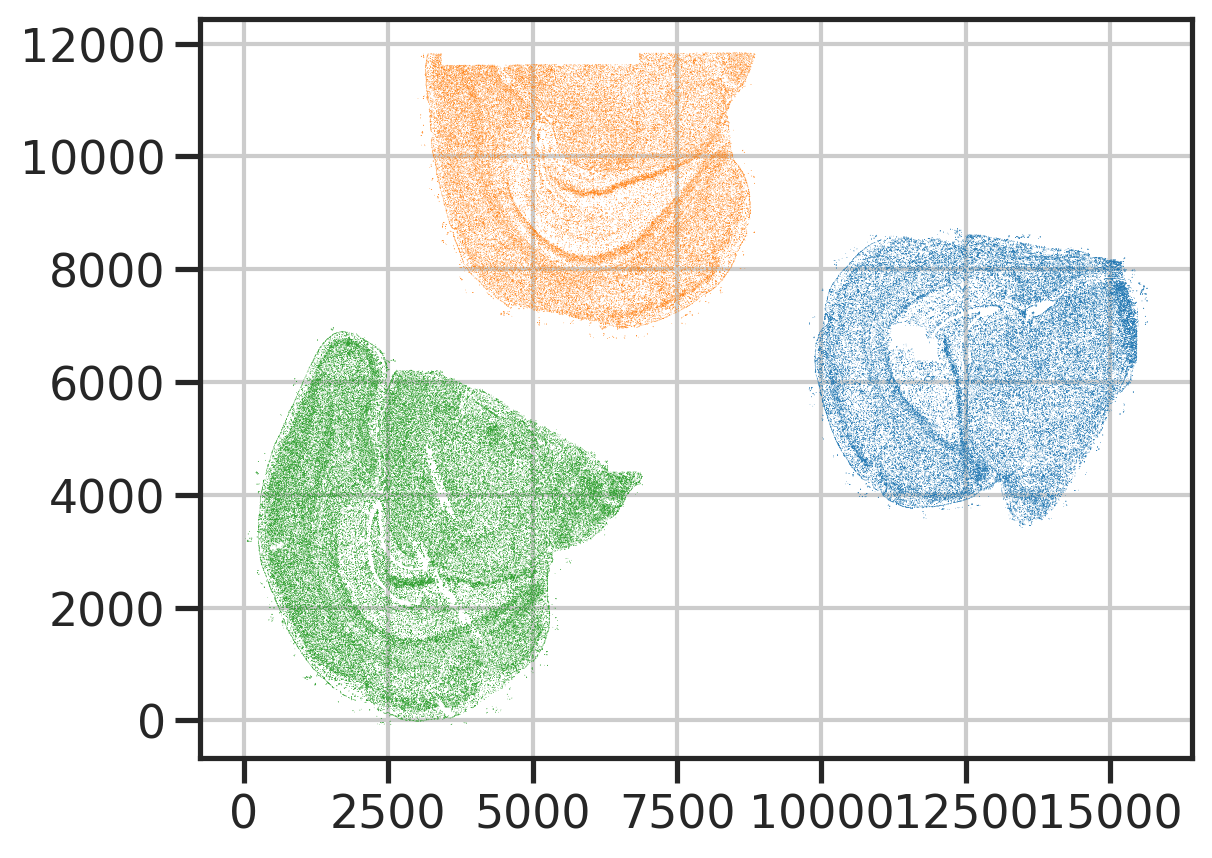

In [9]:
for i in range(len(dfs)): 
    x = dfs[i]['center_x']
    y = dfs[i]['center_y']
    plt.scatter(x, y, s=0.05, edgecolor='none')

In [10]:
dfs = []
names = ['P21DR_pos', 'P28DR_pos', 'P21NR_pos']
for name in names:
    dirc = directories[name]
    f2 = os.path.join('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish', dirc, 'cell_metadata.csv')
    df2 = pd.read_csv(f2)
    dfs.append(df2)

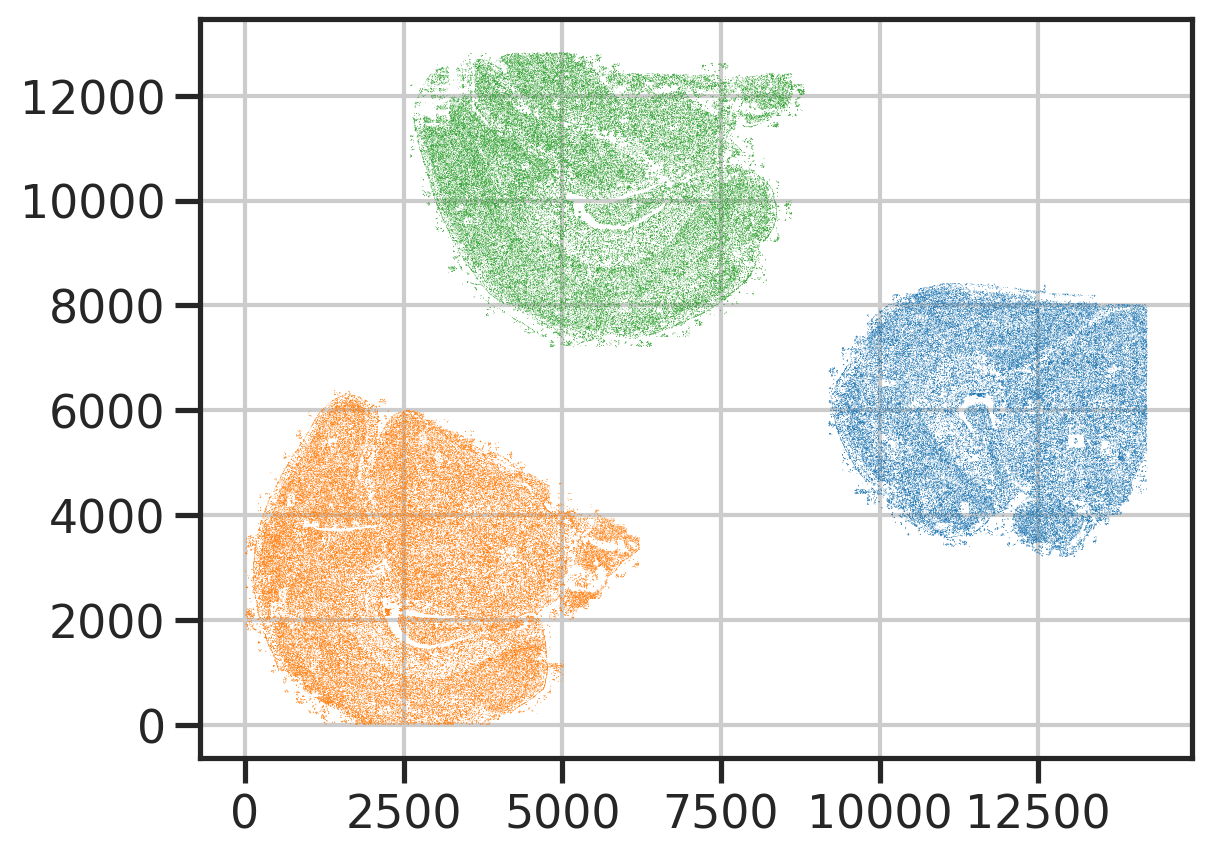

In [11]:
for i in range(len(dfs)): 
    x = dfs[i]['center_x']
    y = dfs[i]['center_y']
    plt.scatter(x, y, s=0.05, edgecolor='none')